## CONTINUOUS DC SERVO MODEL DISCOVERY

In [1]:
# Importing necessary Libraries

import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as skm

In [2]:
data = scipy.io.loadmat("/home/aman/ACL/Servo-Motor-System-Identification/Data/Training_Set.mat")

In [3]:
class motor_param:
    def  __init__(self, PW, RPM):
        self.Pulse_Width = PW 
        self.Motor_RPM = RPM

In [4]:
anti_clock = motor_param(data["Training_set"][0][0][0][0][0][0], data["Training_set"][0][0][0][0][0][1])

In [5]:
clock = motor_param(data["Training_set"][0][0][1][0][0][0], data["Training_set"][0][0][1][0][0][1])

Text(0, 0.5, 'Motor_RPM')

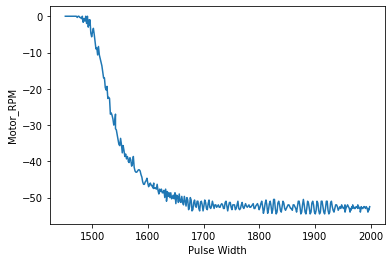

In [6]:
plt.plot(anti_clock.Pulse_Width, anti_clock.Motor_RPM)
plt.xlabel("Pulse Width")
plt.ylabel("Motor_RPM")

### Noise Removal
Denoising the data by using moving average filter with a window size of 4


In [7]:
def moving_avg(data, win_sz):
    fil = np.zeros((len(data), 1))
    for i in range(len(data)):
        if i < len(data) - win_sz:
            fil[i] = np.mean(data[i:i+win_sz])
        elif i< len(data)-1:
            fil[i] = np.mean(data[i:-1])
        else:
            fil[i] = data[i]
            
    return fil

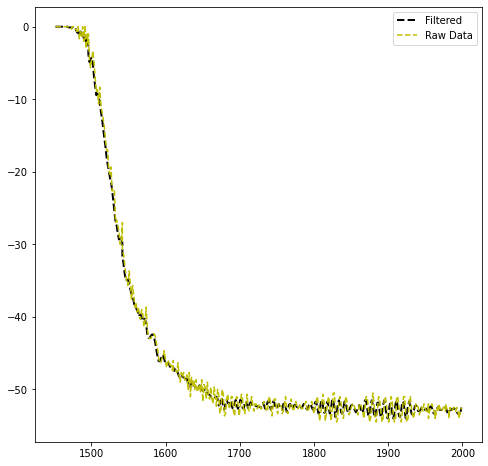

In [8]:
y_fil_anti =  moving_avg(anti_clock.Motor_RPM, 3)

#Plots

plt.figure(figsize = (8, 8))
plt.plot(anti_clock.Pulse_Width, y_fil_anti, "--k", linewidth = 2, label = "Filtered")
plt.plot(anti_clock.Pulse_Width, anti_clock.Motor_RPM, "--y", label = "Raw Data")
plt.legend()

### Regression model
Using Least square regression for parameter identification

In [9]:
def ls(y,A):
    x = np.linalg.inv(A.T @ A) @ A.T @ y
    return x

In [10]:
def motor_function(x, a, b, c, d, e, f):
    y = a/(b + f * np.exp(c*(x - d))) + e
    return y

### Modelling
Fitting the data to the following function of Pulse Width $$\left[y = \frac{a}{b + ke^{-c(x-d)}} + e\right]$$ 
Where:-<br>$y$:- Motor RPM <br> $x$:- Pulse Width <br> $b$:- is constant

In [11]:
from scipy.optimize import curve_fit

In [24]:
p0 = [50, 1, 0.02, 1550, -50, 0.6]    #Initial Guess

In [25]:
ppot, _ = curve_fit(motor_function, anti_clock.Pulse_Width[:, 0], anti_clock.Motor_RPM[:, 0], p0, method="trf")

In [26]:
[a, b, c, d, e, f] = ppot

In [27]:
ppot

array([ 7.18214528e+01,  1.23285521e+00,  3.73631480e-02,  1.52716293e+03,
       -5.21850236e+01,  1.01121273e+00])

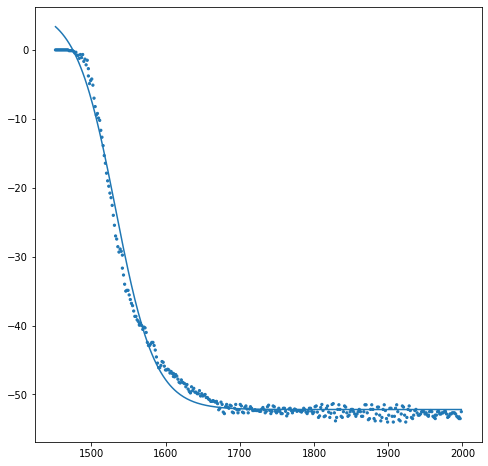

In [28]:
y_pre = np.zeros((len(y_fil_anti), 1))

for i in range(len(y_fil_anti)):
    y_pre[i] = motor_function(anti_clock.Pulse_Width[i], a, b, c, d, e, f)
    

plt.figure(figsize = (8, 8))
plt.plot(anti_clock.Pulse_Width, y_pre)
plt.scatter(anti_clock.Pulse_Width, y_fil_anti, 5*np.ones(len(anti_clock.Pulse_Width)))

In [29]:
skm.mean_squared_error(anti_clock.Motor_RPM, y_pre)

2.4299838207700195

Thus we get the follwing function of the continuous DC servo motor for anti-clockwise rotation
$$\left[y = \frac{71.8214528}{1.23285521 + 1.01121273 * e^{0.0373631480(x - 1527.16293)}} - 52.1850236 \right]$$
Where, <br>
$y:-$ Motor RPM <br>
$x:-$ Pulse Width

### Clockwise Rotation data of the Motor

In [ ]:
plt.plot(clock.Pulse_Width, clock.Motor_RPM)
plt.xlabel("Pulse Width")
plt.ylabel("Motor RPM")

#### Noise Removal(Not Required)
Denoising the data by using moving average filter with a window size of 3

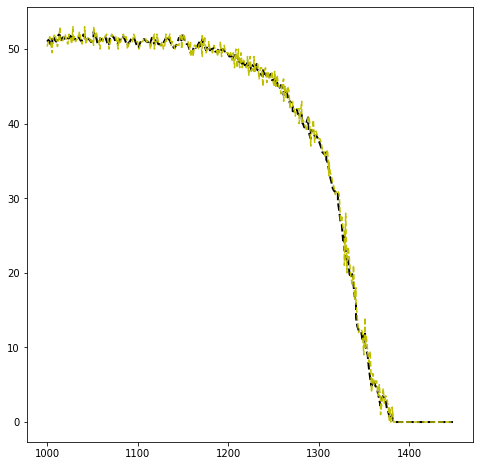

In [36]:
y_clock_fil = moving_avg(clock.Motor_RPM, 3)

plt.figure(figsize = (8, 8))
plt.plot(clock.Pulse_Width, y_clock_fil, "--k", linewidth = 2)
plt.plot(clock.Pulse_Width, clock.Motor_RPM, "--y")

## Clockwise Rotation
Here we will assume a similar function as above to which we will fit the data.
$$y = \frac{a}{b + ke^{-c(x - d)}} + e$$

In [37]:
p0_2 = [50, 3, 0.02, 1250, 50, 1] #initial guess

In [38]:
ppot2, _ = curve_fit(motor_function, clock.Pulse_Width[:, 0], clock.Motor_RPM[:, 0], p0_2, method="trf")

In [39]:
ppot2

array([ 4.73155315e+01,  8.99019840e-01,  4.01891511e-02,  1.23076300e+03,
       -2.25295536e+00,  1.93653666e-02])

In [40]:
[a_c, b_c, c_c, d_c, e_c, f_c] = ppot2

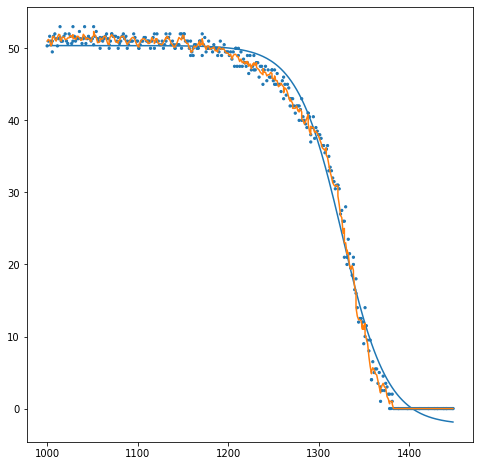

In [41]:
y_pre_2 = np.zeros((len(clock.Motor_RPM), 1))

for i in range(len(y_pre_2)):
    y_pre_2[i] = motor_function(clock.Pulse_Width[i], a_c, b_c, c_c, d_c, e_c, f_c)
    

plt.figure(figsize = (8, 8))
plt.plot(clock.Pulse_Width, y_pre_2)
plt.plot(clock.Pulse_Width, y_clock_fil)
plt.scatter(clock.Pulse_Width, clock.Motor_RPM, 5*np.ones(len(clock.Pulse_Width)))

In [42]:
skm.mean_squared_error(clock.Motor_RPM, y_pre_2)

2.886385228408665

In [43]:
np.where(y_pre_2<0)

(array([343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355,
        356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
        369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [44]:
np.log(((56.3790193/(0 + 52.1850213)) - 0.967777697)/0.619365921)/0.0373632001 + 1520.52209

1474.8905066439402

Thus we get the following function for clockwise rotation of continuous DC Servo Motor
$$y = \left[\frac{47.3155315}{0.899019840 + 0.0193653666 e^{0.0401891511(x - 1230.76300)}} - 2.25295536 \right]$$

2) Without Using in-built functions

In [ ]:
# variables
b_anti = -50
c_anti = 80
d_anti = 1520.5221*1e-6

In [ ]:
# function to create matrix

def matrix_anti(PWM, b, c, d):
    A = np.zeros([len(PWM),2])
    
    for i in range(len(PWM)):
        A[i, 0] = 1/(b + np.exp(c*(PWM[i] - d)))
        A[i, 1] = 1
        
    return A

In [ ]:
A_anti = matrix_anti(anti_clock.Pulse_Width, b_anti, c_anti, d_anti)
x_anti = ls(anti_clock.Motor_RPM, A_anti)

In [ ]:
a_anti = x_anti[0]
e_anti = x_anti[1]

In [ ]:
x_anti

In [ ]:
def anti_clock_model(PWM, a, b, c, d, e):
    y = np.zeros(PWM.shape)
    
    for i in range(len(PWM)):
        y[i] = a/(b + np.exp(c*(PWM[i] - d))) + e
        
    return y

In [ ]:
y_pred_anti = anti_clock_model(anti_clock.Pulse_Width, a_anti, b_anti, c_anti, d_anti, e_anti)

In [ ]:
plt.plot(anti_clock.Pulse_Width, y_pred_anti)
plt.plot(anti_clock.Pulse_Width, anti_clock.Motor_RPM)

In [ ]:
skm.mean_squared_error(anti_clock.Motor_RPM, y_pred_anti)

3) Using tanh() function

In [ ]:
def tan_h(PW, a, b, c):
    y = a * np.tanh(PW - b) + c
    return y

In [ ]:
p0_tan = [-1, 1500, 25] 

In [ ]:
ppot_tan, _ = curve_fit(tan_h, anti_clock.Pulse_Width[:, 0], anti_clock.Motor_RPM[:, 0], p0_tan, method="trf")

In [ ]:
[a_tan, b_tan, c_tan] = ppot_tan

In [ ]:
ppot_tan

In [ ]:
y_pre_tan = np.zeros((len(anti_clock.Motor_RPM), 1))

for i in range(len(y_pre_tan)):
    y_pre_tan[i] = tan_h(anti_clock.Pulse_Width[i], a_tan, b_tan, c_tan)
    

plt.figure(figsize = (8, 8))
plt.plot(anti_clock.Pulse_Width, y_pre_tan)
#plt.plot(clock.Pulse_Width, y_clock_fil)
plt.scatter(anti_clock.Pulse_Width, anti_clock.Motor_RPM, 5*np.ones(len(anti_clock.Pulse_Width)))